# gdelt_gold_exploration.ipynb – Exploración del output Gold (local)
Este notebook analiza el output Gold local generado por el pipeline

NOTA: Antes de ejecutar, favor de correr el requirements.txt que se encuentra en este mismo folder.

In [7]:
import os
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

from pathlib import Path
from dotenv  import load_dotenv

pd.set_option("display.max_columns", 50)
REPO_ROOT = Path(".").resolve()

load_dotenv()

True

## 1) Cargar Gold local (df_risk_monitor)

In [8]:
ingestionDate = "2026-01-24"

local_out_dir = os.getenv("LOCAL_OUT_DIR", "../data/output")
gold_path = f"{local_out_dir}/gold/events/ingestion_date={ingestionDate}/gdelt_gold_{ingestionDate}.csv"

if not os.path.exists(gold_path):
    raise FileNotFoundError(f"No encontré el archivo Gold en: {gold_path}")
    
df_risk_monitor = pd.read_csv(gold_path)

print("--------------------------------------------------------------------------------------------------------------")
print("Loaded Gold CSV: ", gold_path, "\nrows:", len(df_risk_monitor))
print("--------------------------------------------------------------------------------------------------------------")

# Normalizar tipos
for col in ["DTE_EVENT", "DTE_INGESTION"]:
    if col in df_risk_monitor.columns:
        df_risk_monitor[col] = pd.to_datetime(df_risk_monitor[col], errors="coerce").dt.date
    
for c in ["CNT_EVENTS","NUM_GOLDSTEIN_AVG","NUM_RISK_SCORE"]:
    if c in df_risk_monitor.columns:
        df_risk_monitor[c] = pd.to_numeric(df_risk_monitor[c], errors="coerce")
    
df_risk_monitor.head()

--------------------------------------------------------------------------------------------------------------
Loaded Gold CSV:  ../data/output/gold/events/ingestion_date=2026-01-24/gdelt_gold_2026-01-24.csv 
rows: 29
--------------------------------------------------------------------------------------------------------------


,DTE_EVENT,NAM_COUNTRY,NAM_CITY,CNT_EVENTS,NUM_GOLDSTEIN_AVG,NUM_RISK_SCORE,DTE_INGESTION
0,2026-01-24,CA,Toronto,2,-0.950000,47.5,2026-01-24
1,2026-01-24,CA,Vancouver,5,-0.460000,47.5,2026-01-24
2,2026-01-24,IR,Mashhad,1,-5.000000,140.0,2026-01-24
3,2026-01-24,JP,Tokyo,3,-0.400000,37.5,2026-01-24
4,2026-01-24,IR,Isfahan,11,-6.036364,140.0,2026-01-24


## 2) Top 20 de eventos por riesgo

In [9]:
top = df_risk_monitor.sort_values("NUM_RISK_SCORE", ascending=False).head(20)
top[["DTE_EVENT","NAM_COUNTRY","NAM_CITY","CNT_EVENTS","NUM_GOLDSTEIN_AVG","NUM_RISK_SCORE"]]

,DTE_EVENT,NAM_COUNTRY,NAM_CITY,CNT_EVENTS,NUM_GOLDSTEIN_AVG,NUM_RISK_SCORE
2,2026-01-24,IR,Mashhad,1,-5.000000,140.00
4,2026-01-24,IR,Isfahan,11,-6.036364,140.00
26,2026-01-24,IR,Tehran,9,-6.522222,136.11
21,2026-01-24,IR,Shiraz,14,-7.035714,130.00
23,2026-01-24,FR,Paris,5,-4.800000,108.00
15,2026-01-24,MX,Monterrey,6,-3.350000,104.17
24,2026-01-24,MX,Ciudad Juarez,7,-3.414286,102.68
7,2026-01-24,FR,Marseille,11,-4.509091,100.91
19,2026-01-24,FR,Lyon,9,-3.744444,96.67
6,2026-01-24,MX,Guadalajara,5,-3.560000,93.75


## 3) Tendencia temporal

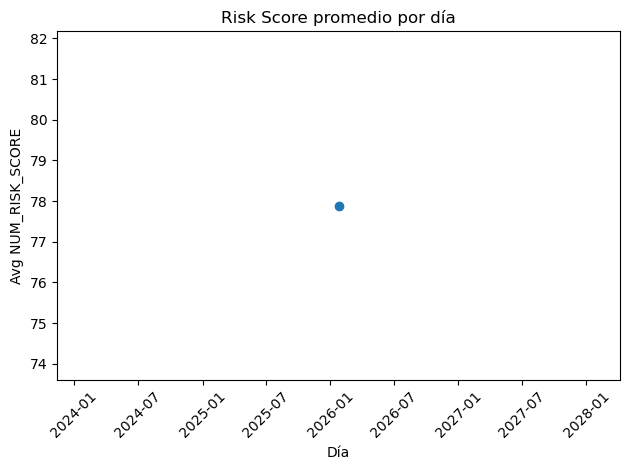

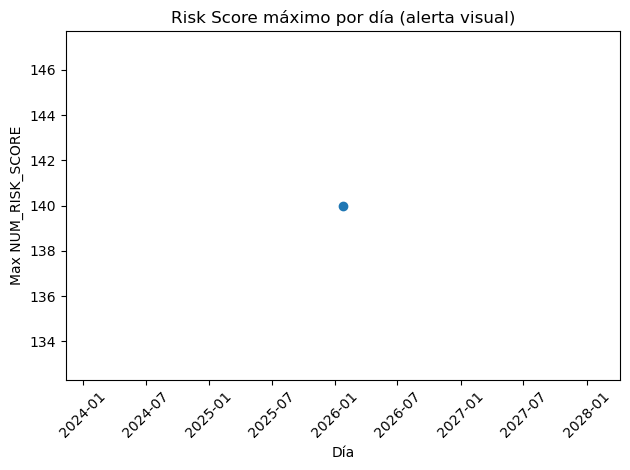

,DTE_EVENT,total_events,avg_score,max_score
0,2026-01-24,150,77.891379,140.0


In [26]:
ts = df_risk_monitor.groupby("DTE_EVENT", as_index=False).agg(total_events = ("CNT_EVENTS","sum")     , 
                                                              avg_score    = ("NUM_RISK_SCORE","mean"), 
                                                              max_score    = ("NUM_RISK_SCORE","max")).sort_values("DTE_EVENT")

plt.figure()
plt.plot(ts["DTE_EVENT"], ts["avg_score"], marker="o")
plt.xticks(rotation=45)
plt.title("Risk Score promedio por día")
plt.xlabel("Día")
plt.ylabel("Avg NUM_RISK_SCORE")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(ts["DTE_EVENT"], ts["max_score"], marker="o")
plt.xticks(rotation=45)
plt.title("Risk Score máximo por día (alerta visual)")
plt.xlabel("Día")
plt.ylabel("Max NUM_RISK_SCORE")
plt.tight_layout()
plt.show()

ts.head()


## 4) Top 15 de distribución por país

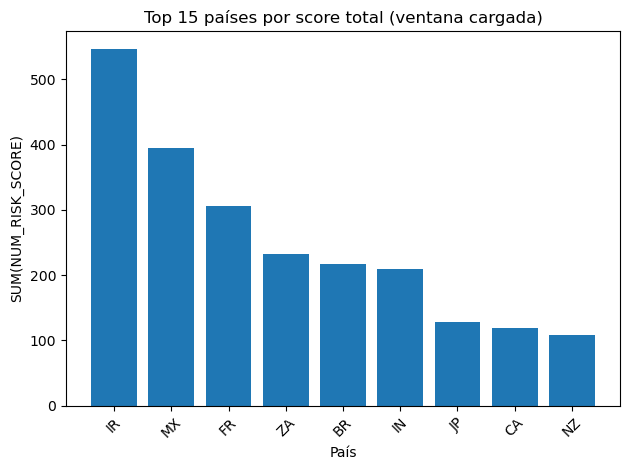

,NAM_COUNTRY,total_score,total_events
4,IR,546.11,35
6,MX,394.35,20
2,FR,305.58,25
8,ZA,232.05,15
0,BR,217.71,15
3,IN,209.13,15
5,JP,127.50,8
1,CA,118.75,8
7,NZ,107.67,9


In [22]:
top_countries = (df_risk_monitor.groupby("NAM_COUNTRY", as_index=False).agg(total_score=("NUM_RISK_SCORE","sum"), total_events=("CNT_EVENTS","sum")).sort_values("total_score", ascending=False).head(15))

plt.figure()
plt.bar(top_countries["NAM_COUNTRY"], top_countries["total_score"])
plt.title("Top 15 países por score total (ventana cargada)")
plt.xlabel("País")
plt.ylabel("SUM(NUM_RISK_SCORE)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

top_countries

## 5) Componentes típicos del riesgo + score propuesto

In [23]:
w_vol  = 0.6
w_conf = 0.4
vol    = np.log1p(df_risk_monitor["CNT_EVENTS"].fillna(0))
conf   = (-df_risk_monitor["NUM_GOLDSTEIN_AVG"]).clip(lower=0)
corr   = df_risk_monitor[["NUM_RISK_SCORE","RISK_SCORE_PROPOSED"]].corr().iloc[0,1]

df_risk_monitor["_vol_norm"]           = (vol - vol.min()) / (vol.max() - vol.min() + 1e-9)
df_risk_monitor["_conf_norm"]          = (conf - conf.min()) / (conf.max() - conf.min() + 1e-9)
df_risk_monitor["RISK_SCORE_PROPOSED"] = 100 * (w_vol * df_risk_monitor["_vol_norm"] + w_conf * df_risk_monitor["_conf_norm"])
df_risk_monitor[["DTE_EVENT","NAM_COUNTRY","NAM_CITY","CNT_EVENTS","NUM_GOLDSTEIN_AVG","NUM_RISK_SCORE","RISK_SCORE_PROPOSED"]].head(10)

,DTE_EVENT,NAM_COUNTRY,NAM_CITY,CNT_EVENTS,NUM_GOLDSTEIN_AVG,NUM_RISK_SCORE,RISK_SCORE_PROPOSED
0,2026-01-24,CA,Toronto,2,-0.950000,47.50,16.635509
1,2026-01-24,CA,Vancouver,5,-0.460000,47.50,34.422741
2,2026-01-24,IR,Mashhad,1,-5.000000,140.00,28.145581
3,2026-01-24,JP,Tokyo,3,-0.400000,37.50,21.999364
4,2026-01-24,IR,Isfahan,11,-6.036364,140.00,87.535765
5,2026-01-24,IN,Delhi,6,-1.816667,70.00,46.913230
6,2026-01-24,MX,Guadalajara,5,-3.560000,93.75,52.474734
7,2026-01-24,FR,Marseille,11,-4.509091,100.91,78.642114
8,2026-01-24,NZ,Christchurch,5,-0.380000,29.75,33.956883
9,2026-01-24,ZA,Cape Town,4,-2.525000,79.06,41.018507


## 6) Visual: volumen vs severidad

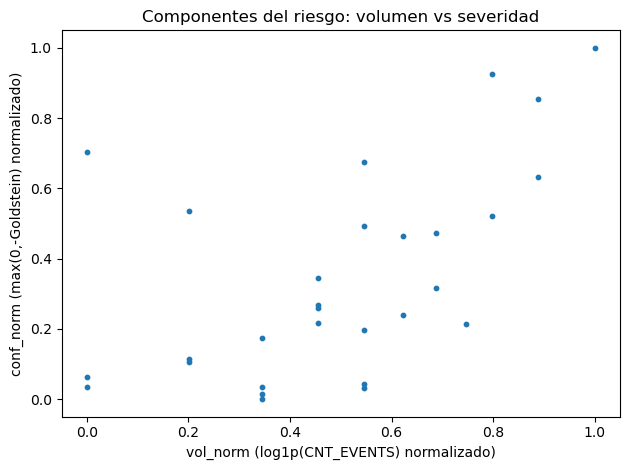

In [24]:
plt.figure()
plt.scatter(df_risk_monitor["_vol_norm"], df_risk_monitor["_conf_norm"], s=10)
plt.title("Componentes del riesgo: volumen vs severidad")
plt.xlabel("vol_norm (log1p(CNT_EVENTS) normalizado)")
plt.ylabel("conf_norm (max(0,-Goldstein) normalizado)")
plt.tight_layout()
plt.show()

## 7) Niveles de alerta (para Looker Studio)

In [25]:
def risk_level(score: float) -> str:
    if pd.isna(score):
        return "UNKNOWN"
    if score >= 75:
        return "CRÍTICO"
    if score >= 60:
        return "ALTO"
    if score >= 40:
        return "MEDIO"
    return "BAJO"
    
df_risk_monitor["RISK_LEVEL"] = df_risk_monitor["NUM_RISK_SCORE"].apply(risk_level)
df_risk_monitor["RISK_LEVEL"].value_counts(dropna=False)

RISK_LEVEL
CRÍTICO    14
ALTO        6
MEDIO       5
BAJO        4
Name: count, dtype: int64